## Etapas da Aula
- Funções para Extração de Parâmetros e Resolução da Equação Característica da Curva IV (De Soto)

- Características do Módulo FV e Condição de STC

1) Extração de Parâmetros dos Pontos da Curva IV do Datasheet (Métodos da De Soto)

2) Resolvendo a Equação Característica do SDM 5 P (Métodos do Lambert-W, Newton-Raphson e Bishop)

-> Desafio 1: Adaptar a Equação Característica do SDM 5-Param para:
- 5 módulos em Série
- 3 Módulos em Paralelo

-> Desafio 2: Determinem o Fator de Idealidade do Módulo

-> Desafio 3: Fazer o Método do CEC para Extração de Parâmetros do Datasheet e Cálculo de Parâmetros do SDM

3) Modelagem da Curva IV com a Variação de Temperatura e Irradiância

In [1]:
#!pip install pvlib

In [2]:
import pvlib
from pvlib import pvsystem
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.constants import Boltzmann, elementary_charge

### Funções para Extração de Parâmetros e Resolução da Equação Característica da Curva IV (De Soto)
- As duas funções que estão aqui definem os parâmetros do Single Diode Model sob condições de STC (Padrão de Teste em Laboratório) e OPC (Operação)

In [3]:
def desotorefparameters(Vmp, Imp, Voc, Isc, alpha, beta, Ns, EgRef, dEgdT, Tref, Gref):
    desoto_fit_params = pvlib.ivtools.sdm.fit_desoto(Vmp,
                                                     Imp,
                                                     Voc, 
                                                     Isc,
                                                     alpha,
                                                     beta,
                                                     Ns,
                                                     EgRef,
                                                     dEgdT,
                                                     Tref, 
                                                     Gref,
                                                     root_kwargs = {'method': 'lm', 'options':{'maxiter':10000, 'xtol': 1e-3, 'gtol': 1e-3}})
    desoto_fit_params[0]

    fitted_params = desoto_fit_params[0]

    desoto_params_dict = fitted_params

    results_df_desoto = pd.DataFrame(columns = ['a_ref', 'Ipv_ref', 'Io_ref', 'Rp_ref', 'R_s'])

    results_df_desoto.loc[1] = [desoto_params_dict['a_ref'], desoto_params_dict['I_L_ref'], desoto_params_dict['I_o_ref'],
                                desoto_params_dict['R_sh_ref'], desoto_params_dict['R_s']]
    return(results_df_desoto)

In [4]:
def desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref, Rp_ref, R_s, EgRef, dEgdT, Gref, Tref, method = 'lambertw', number_of_points = 100):
    diode_params_desoto = pvlib.pvsystem.calcparams_desoto(irrad, 
                                                          temp_cell, 
                                                          alpha, 
                                                          a_ref, 
                                                          Ipv_ref, 
                                                          Io_ref, 
                                                          Rp_ref, 
                                                          R_s, 
                                                          EgRef, 
                                                          dEgdT, 
                                                          Gref, 
                                                          Tref)
    SDE_params = {
        'photocurrent': diode_params_desoto[0],
        'saturation_current': diode_params_desoto[1],
        'resistance_series': diode_params_desoto[2],
        'resistance_shunt': diode_params_desoto[3],
        'nNsVth': diode_params_desoto[4]
    }

    curve_info = pvsystem.singlediode(method=method, **SDE_params)
    v = pd.DataFrame(np.linspace(0, curve_info['v_oc'], number_of_points))
    i = pd.DataFrame(pvsystem.i_from_v(voltage=v, method=method, **SDE_params))

    return ({'Key_Points': curve_info,
             'Voltage': v,
             'Current': i})

In [5]:
#Constantes necessárias para a modelagem em STC
EgRef=1.121 #Valence energy band-gap for Crystalline Silicon
dEgdT=- 0.0002677 #
Tref = 25 #Temperature (°C) under STC
Gref = 1000 #Irradiance (W/m²) under STC
k = Boltzmann
q = elementary_charge

### Características do Módulo FV e Condição de STC
- Aqui você pode colocar os parâmetros elétricos de qualquer datasheet de módulo FV para extrair os parâmetros elétricos do Single Diode Model


In [6]:
Vmp = 30.8 #Voltage at Maximum Power
Imp = 8.75 #Current at Maximum Power
Voc = 37.9 #Open-Circuit Voltage
Isc = 9.32 #Short-Circuit Current
alpha = 0.05*Isc/100 # Alpha_isc (%/A) * Short-Circuit Current
beta = (-0.31)*Voc/100 # Beta_voc (%/V) * Open-Circuit Voltage
gamma = -0.41
Ns = 60 #Number of PV Cells in Series
A_c = 1.6368 #The Area of PV Module's Surface

In [7]:
# Condições de Irradiância em STC (1000 W/m² e 25°C)
irrad = 1000
temp_cell = 25

### 1) Extração de Parâmetros dos Pontos da Curva IV do Datasheet (Métodos da De Soto)

In [8]:
desoto_ref_parameters = desotorefparameters(Vmp, Imp, Voc, Isc, alpha, beta, Ns, EgRef, dEgdT, Tref, Gref)
print('Os 5 parâmetros do SDM em STC')
desoto_ref_parameters

Os 5 parâmetros do SDM em STC


,a_ref,Ipv_ref,Io_ref,Rp_ref,R_s
1,1.466828,9.331172,5.510302e-11,256.566134,0.306243


### 2) Resolvendo a Equação Característica do SDM 5 P (Métodos do Lambert-W, Newton-Raphson e Bishop)

In [9]:
a_ref = desoto_ref_parameters['a_ref'][1]
Ipv_ref = desoto_ref_parameters['Ipv_ref'][1]
Io_ref = desoto_ref_parameters['Io_ref'][1]
Rp_ref = desoto_ref_parameters['Rp_ref'][1]
R_s = desoto_ref_parameters['R_s'][1]

results = desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref, Rp_ref, R_s, EgRef, dEgdT, Gref, Tref, method = 'lambertw', number_of_points = 100)
print('Pontos chave da Curva IV')
results['Key_Points']

Pontos chave da Curva IV


{'i_sc': 9.320047289526327,
 'v_oc': 37.90170030774971,
 'i_mp': 8.749983509405975,
 'v_mp': 30.80051909121857,
 'p_mp': 269.5040341293064,
 'i_x': 9.246117079837894,
 'i_xx': 6.20733674944824}

Curva IV em STC destacando o Ponto de Máxima Potência


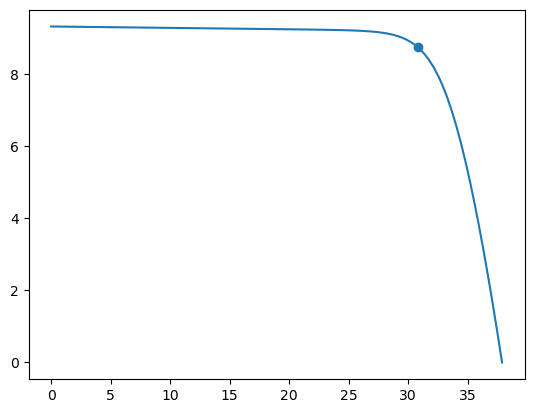

In [10]:
print('Curva IV em STC destacando o Ponto de Máxima Potência')
plt.plot(results['Voltage'], results['Current'])
plt.scatter(results['Key_Points']['v_mp'], results['Key_Points']['i_mp'])
plt.show()

In [11]:
print('Calculando o Fator de Forma da Curva IV')
FF = (results['Key_Points']['i_mp']*results['Key_Points']['v_mp'])/(results['Key_Points']['i_sc']*results['Key_Points']['v_oc'])
print(FF)

Calculando o Fator de Forma da Curva IV
0.7629366203164286


### Desafio 1: Adaptar a Equação Característica do SDM 5-Param para:

- 5 módulos em Série

- 3 Módulos em Paralelo

{'i_sc': 27.960141868578983, 'v_oc': 189.50850153874853, 'i_mp': 26.249950510281632, 'v_mp': 154.00259556132107, 'p_mp': 4042.560511939596, 'i_x': 27.738351239513687, 'i_xx': 18.622010208740967}


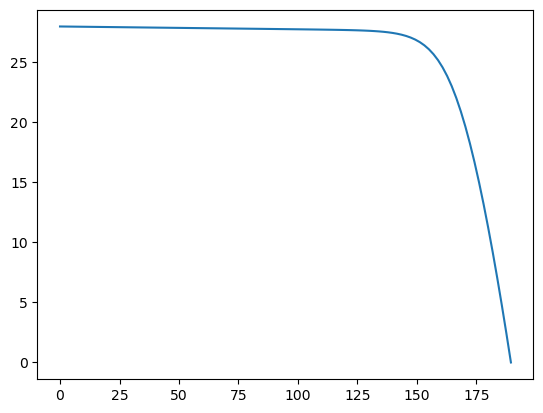

In [12]:
Nms = 5
Nmp = 3

a_ref = desoto_ref_parameters['a_ref'][1]*Nms
Ipv_ref = desoto_ref_parameters['Ipv_ref'][1]*Nmp
Io_ref = desoto_ref_parameters['Io_ref'][1]*Nmp
Rp_ref = desoto_ref_parameters['Rp_ref'][1]*Nms/Nmp
R_s = desoto_ref_parameters['R_s'][1]*Nms/Nmp

results = desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref, Rp_ref, R_s, EgRef, dEgdT, Gref, Tref, method = 'lambertw', number_of_points = 100)
print(results['Key_Points'])

plt.plot(results['Voltage'], results['Current'])
plt.show()

### Desafio 2: Determinem o Fator de Idealidade do Módulo

In [13]:
desoto_ref_parameters['a_ref']

1    1.466828
Name: a_ref, dtype: float64

In [14]:
Vt = k/q*(Tref + 273.15)
n = desoto_ref_parameters['a_ref']/(Ns*Vt)
print(n)

1    0.951525
Name: a_ref, dtype: float64


### Desafio 3: Fazer o Método do CEC para Extração de Parâmetros do Datasheet e Cálculo de Parâmetros do SDM

In [15]:
#!pip install NREL-PySAM

In [16]:
celltype = 'polySi'
cec_fit_params = pvlib.ivtools.sdm.fit_cec_sam(celltype, Vmp, Imp, Voc, Isc, alpha, beta, gamma, Ns, Tref)

print('Ipv, Io, Rs, Rp, a, Adjust')
print(cec_fit_params)

Ipv, Io, Rs, Rp, a, Adjust
(9.3295038346468, 1.2260000881764844e-10, 0.2947913973553517, 289.0892053279882, 1.5135103456529186, 7.684762576630363)


In [17]:
Ipv_ref = cec_fit_params[0]
Io_ref = cec_fit_params[1]
R_s = cec_fit_params[2]
Rp_ref = cec_fit_params[3]
a_ref = cec_fit_params[4]
Adjust = cec_fit_params[5]

cec_params_opc = pvlib.pvsystem.calcparams_cec(irrad, temp_cell, alpha, a_ref,
                                            Ipv_ref, Io_ref, Rp_ref,
                                            R_s, Adjust)
print('Os 5 Parâmetros do SDM em STC determinados pelo método do CEC')
cec_params_opc

Os 5 Parâmetros do SDM em STC determinados pelo método do CEC


(9.3295038346468,
 1.2260000881764844e-10,
 0.2947913973553517,
 289.0892053279882,
 1.5135103456529186)

In [18]:
SDE_params_cec = {
    'photocurrent': cec_params_opc[0],
    'saturation_current': cec_params_opc[1],
    'resistance_series': cec_params_opc[2],
    'resistance_shunt': cec_params_opc[3],
    'nNsVth': cec_params_opc[4]
    }

curve_info = pvsystem.singlediode(method='lambertw', **SDE_params_cec)
v = pd.DataFrame(np.linspace(0, curve_info['v_oc'], 100))
i = pd.DataFrame(pvsystem.i_from_v(voltage=v, method='lambertw', **SDE_params_cec))

print('Pontos-chave da curva IV')
curve_info

Pontos-chave da curva IV


{'i_sc': 9.319999999999952,
 'v_oc': 37.90000000000009,
 'i_mp': 8.750000035338358,
 'v_mp': 30.799999875607917,
 'p_mp': 269.4999999999907,
 'i_x': 9.254312619038513,
 'i_xx': 6.23581550498219}

### 3) Modelagem da Curva IV com a Variação de Temperatura e Irradiância

In [19]:
# Variando a Irradiância e Mantendo a Temperatura Constante
irrad = np.array([200, 400, 600, 800, 1000])
temp_cell = np.array([25, 25, 25, 25, 25])

In [20]:
results = desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref, Rp_ref, R_s, EgRef, dEgdT, Gref, Tref, method = 'lambertw', number_of_points = 100)
results['Key_Points']

,i_sc,v_oc,i_mp,v_mp,p_mp,i_x,i_xx
0,1.865520,35.465484,1.756472,30.346531,53.302822,1.853233,1.397291
1,3.730280,36.513973,3.511638,30.876970,108.428728,3.704985,2.713974
2,5.594280,37.127300,5.262759,30.993703,163.112397,5.555698,3.952924
3,7.457519,37.562462,7.009073,30.942312,216.876934,7.405461,5.123605
4,9.320000,37.900000,8.750000,30.800000,269.500000,9.254313,6.235816


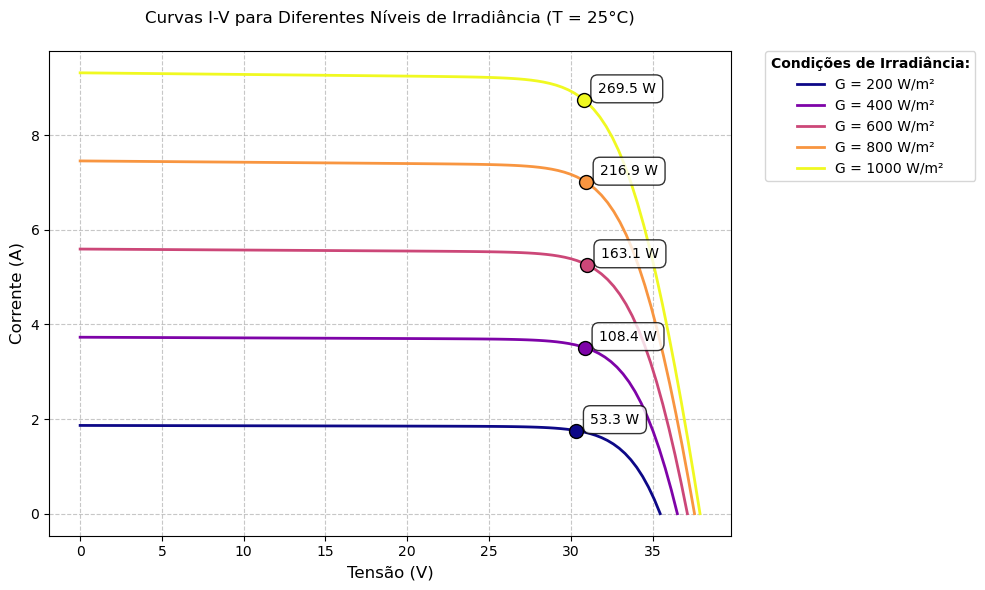

In [21]:
# Variando a Irradiância e Mantendo a Temperatura Constante
irrad = np.array([200, 400, 600, 800, 1000])  # Valores de irradiância em W/m²
temp_cell = np.array([25, 25, 25, 25, 25])    # Temperatura constante em °C

results = desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref, Rp_ref, R_s, EgRef, dEgdT, Gref, Tref, method='lambertw', number_of_points=100)
key_points = results['Key_Points']

# Configurações do gráfico
plt.figure(figsize=(10, 6))
colors = plt.cm.plasma(np.linspace(0, 1, len(irrad)))  # Paleta de cores diferente para irradiância

for i, G in enumerate(irrad):
    # Curva I-V
    plt.plot(results['Voltage'][i], results['Current'][i], 
             color=colors[i],
             linewidth=2,
             label=f'G = {G} W/m²')
    
    # Ponto de máxima potência
    plt.scatter(key_points["v_mp"][i], key_points["i_mp"][i], 
                color=colors[i], 
                s=100, 
                edgecolor='black',
                zorder=5)
    
    # Anotação do ponto MPP
    plt.annotate(f'{key_points["p_mp"][i]:.1f} W', 
                 (key_points["v_mp"][i], key_points["i_mp"][i]),
                 textcoords="offset points",
                 xytext=(10, 5),
                 ha='left',
                 bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8))

# Elementos do gráfico
plt.title('Curvas I-V para Diferentes Níveis de Irradiância (T = 25°C)', pad=20)
plt.xlabel('Tensão (V)', fontsize=12)
plt.ylabel('Corrente (A)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Legenda personalizada
legend = plt.legend(bbox_to_anchor=(1.05, 1), 
                    loc='upper left', 
                    title='Condições de Irradiância:',
                    borderaxespad=0.,
                    fontsize=10)
legend.get_title().set_fontweight('bold')

plt.tight_layout()
plt.show()

In [22]:
# Variando a Temperatura e Mantendo a Irradiância Constante
irrad = np.array([1000, 1000, 1000, 1000, 1000])
temp_cell = np.array([10, 25, 40, 55, 70])

results = desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref, Rp_ref, R_s, EgRef, dEgdT, Gref, Tref, method = 'lambertw', number_of_points = 100)
results['Key_Points']

,i_sc,v_oc,i_mp,v_mp,p_mp,i_x,i_xx
0,9.250171,39.791313,8.726844,32.761472,285.904261,9.181361,6.267855
1,9.320000,37.900000,8.750000,30.800000,269.500000,9.254313,6.235816
2,9.389829,35.998357,8.765648,28.849428,252.883936,9.326999,6.193623
3,9.459658,34.086921,8.772315,26.911968,236.080272,9.398986,6.140248
4,9.529486,32.166181,8.768148,24.990113,219.117010,9.469337,6.074396


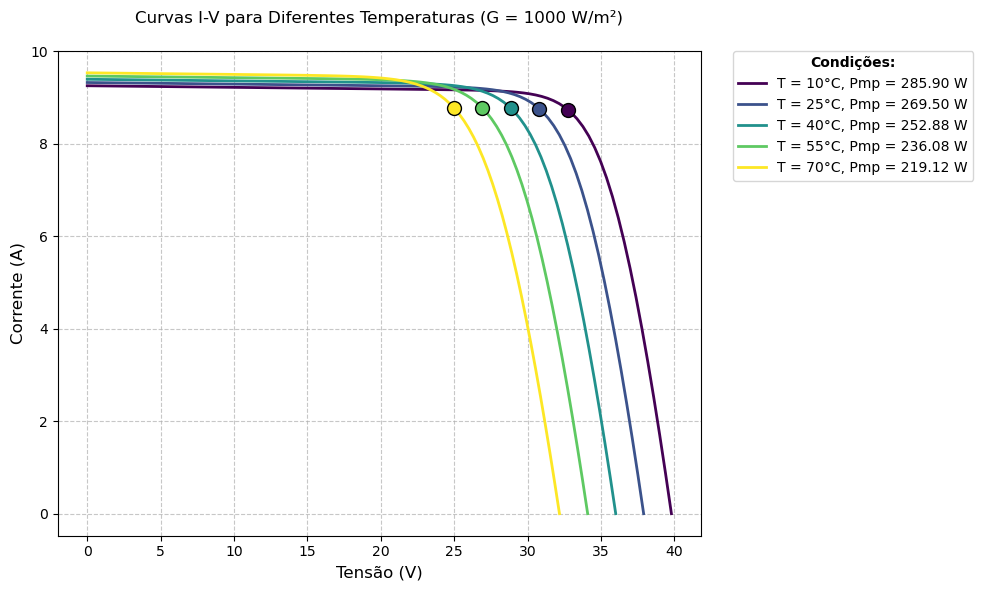

In [23]:
# Variando a Temperatura e Mantendo a Irradiância Constante
irrad = np.array([1000, 1000, 1000, 1000, 1000])  # Irradiância constante em W/m²
temp_cell = np.array([10, 25, 40, 55, 70])        # Valores de temperatura em °C

results = desotoparametersopc(irrad, temp_cell, alpha, a_ref, Ipv_ref, Io_ref, Rp_ref, R_s, EgRef, dEgdT, Gref, Tref, method='lambertw', number_of_points=100)
key_points = results['Key_Points']

# Configurações do gráfico
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(temp_cell)))  # Paleta de cores

for i, temp in enumerate(temp_cell):
    # Curva I-V
    plt.plot(results['Voltage'][i], results['Current'][i], 
             color=colors[i],
             linewidth=2,
             label=f'T = {temp}°C, Pmp = {key_points["p_mp"][i]:.2f} W')
    
    # Ponto de máxima potência
    plt.scatter(key_points["v_mp"][i], key_points["i_mp"][i], 
                color=colors[i], 
                s=100, 
                edgecolor='black',
                zorder=5)
    
    # Anotação do ponto MPP
    '''plt.annotate(f'{key_points["p_mp"][i]:.1f} W', 
                 (key_points["v_mp"][i], key_points["i_mp"][i]),
                 textcoords="offset points",
                 xytext=(10, 5),
                 ha='left',
                 bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8))'''

# Elementos do gráfico
plt.title('Curvas I-V para Diferentes Temperaturas (G = 1000 W/m²)', pad=20)
plt.xlabel('Tensão (V)', fontsize=12)
plt.ylabel('Corrente (A)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Legenda personalizada
legend = plt.legend(bbox_to_anchor=(1.05, 1), 
                    loc='upper left', 
                    title='Condições:',
                    borderaxespad=0.,
                    fontsize=10)
legend.get_title().set_fontweight('bold')

plt.tight_layout()
plt.show()

### Próxima Aula Iremos Estudar:
- Eficiência do Módulo FV em STC e Sob Condições de Operação
- Geração Simulada com Single Diode Model
- Métricas de Desempenho